# Objective

## Problem to solve

Story generator using an RNN (GRU or LSTM).

## Dataset

Plaintext books downloaded from https://www.gutenberg.org/ from the following authors:
* Fyodor Dostoyevsky
    * Crime and Punishment
    * The Brothers Karamazov
* Oscar Wilde
    * The Canterville Ghost
    * The Importance of Being Earnest
    * The Picture of Dorian Gray
    * The Soul of Man under Socialism

Fryodor Dostoyevsky books are the **main** dataset we want to use for training (3.7MB of text). While Oscar Wilde books were used for quicker experimentation as the dataset is smaller (712KB of text).

Though we can really download books from any author to train the model to generate stories in that author's "style".

In [1]:
from rnn_story_gen import *

# Suppress TensorFlow CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set random seed for reproducibility
SEED = 42
keras.utils.set_random_seed(SEED)

2025-12-09 00:04:24.604586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 00:04:24.640321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 00:04:25.433332: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Exploratory Data Analysis

Note that the books were already manually stripped of non-story sections like:
* Table of contents
* Licence
* etc...

In [2]:
text = load_text_data("data/rnn/fyodor_dostoyevsky")
perform_eda(text)

Loading text data from data/rnn/fyodor_dostoyevsky...
  - Reading crime_and_punishment.txt...
  - Reading the_brothers_karamazov.txt...
Total characters loaded: 3061046
EXPLORATORY DATA ANALYSIS
Total Characters: 3061046
Vocabulary Size:  99
Vocabulary:       '\n !()*,-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyzÆàäæçèéêëîïôöüŒœ‐—‘’“”'
----------------------------------------
Top 20 Most Common Characters:
  ' ': 504379 (16.48%)
  'e': 279963 (9.15%)
  't': 211127 (6.90%)
  'a': 188296 (6.15%)
  'o': 188228 (6.15%)
  'n': 160896 (5.26%)
  'i': 148563 (4.85%)
  'h': 148433 (4.85%)
  's': 138705 (4.53%)
  'r': 123619 (4.04%)
  'd': 101956 (3.33%)
  'l': 95661 (3.13%)
  'u': 72438 (2.37%)
  'm': 60151 (1.97%)
  '\n': 59047 (1.93%)
  'y': 57187 (1.87%)
  'w': 51480 (1.68%)
  'c': 49049 (1.60%)
  'f': 46803 (1.53%)
  ',': 46469 (1.52%)
----------------------------------------
First 500 Characters (Check for headers):
----------------------------------------
CRIME AN

## Findings
*   **Volume:** 3.06M characters (~3MB). Sufficient for character-level learning of style and grammar.
*   **Vocabulary:** 99 unique characters. Includes standard alphanumeric, some foreign accents, and typographic punctuation (smart quotes, em-dashes).
*   **Cleanliness:** No Project Gutenberg headers or footers found. Manual cleaning was successful.
*   **Distribution:** Standard English letter frequency (Space ~16%, 'e' ~9%).

The dataset is clean, has a relatively good size, without sacrificing training speed for a Laptop GPU.

# Pre-processing

The preprocessing pipeline for the RNN story generator involves two main steps:

1.  **Text Vectorization:**
    *   A unique vocabulary of all characters in the dataset is created and sorted.
    *   Each character is mapped to a unique integer index (e.g., 'a' -> 0, 'b' -> 1).
    *   The entire raw text is converted into a sequence of these integer indices.
<br>

2.  **Dataset Creation:**
    *   The vectorized text is segmented into sequences of a predefined length (`seq_length`).
    *   For each sequence, input and target pairs are formed: the input is `seq_length` characters long, and the target is the same sequence shifted by one character (predicting the next character).
    *   These input-target pairs are then shuffled and batched into a `tf.data.Dataset` for efficient model training.


In [3]:
# Pre-process text
vocab = sorted(set(text))
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size} unique characters")

char2idx = {u: i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

# Create the dataset
seq_length = 100
batch_size = 64

print(f"Creating dataset (seq_length={seq_length}, batch_size={batch_size})...")

# Initialize the dataset structure and transform it in sequences of a fixed length
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

# Then transform each sequence into a pair of (input, target)
dataset = sequences.map(split_input_target)

# Shuffle and batch
dataset = dataset.shuffle(300_000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

Vocabulary size: 99 unique characters
Creating dataset (seq_length=100, batch_size=64)...


I0000 00:00:1765260266.798075   14067 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5977 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# Model definition

## Architecture

The model implements a standard character-level Recurrent Neural Network (LSTM) using the following architecture:

1.  **Embedding Layer (Input):**
    *   **Input Dimension:** `vocab_size`.
    *   **Output Dimension:** `embedding_dim` (256).

2.  **LSTM Layer (Hidden):**
    *   **Type:** Long Short-Term Memory (`tf.keras.layers.LSTM`).
    *   **Units:** 1024.
    *   **Return Sequences:** `True`
    *   **Note:** This was previously a GRU, and was later changed to an LSTM.

3.  **Dense Layer (Output):**
    *   **Units:** `vocab_size`.
    *   **Purpose:** Outputs the raw logits for the next character in the sequence.


In [4]:
embedding_dim = 256
rnn_units = 1024

model = keras.Sequential([
    layers.Input(batch_shape=(batch_size, None)),
    layers.Embedding(vocab_size, embedding_dim),
    layers.LSTM(
        rnn_units,
        return_sequences=True,
        stateful=False,
        recurrent_initializer='glorot_uniform'),
    layers.Dense(vocab_size)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, None, 256)        │        25,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, None, 1024)       │     5,246,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, None, 99)         │       101,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,373,795 (20.50 MB)

 Trainable params: 5,373,795 (20.50 MB)

 Non-trainable params: 0 (0.00 B)

# Training

## Configuration
*   **Epochs:** 20
*   **Optimizer:** Adam
*   **Loss Function:** `sparse_categorical_crossentropy` (from logits=True)
*   **Batch Size:** 64
*   **Sequence Length:** 100
*   **Checkpointing:** Model weights saved every 3 epochs to `./rnn_checkpoints`.

## Observations
*   **Convergence:** The loss curve started to flatten towards the later epochs, suggesting the model is converging.
*   **Quality Threshold:** A final loss of `0.87` is indicative of a model that has likely learned good grammatical structure and stylistic elements, without necessarily having overfit to the point of memorizing the training text verbatim.


Training RNN model (saving every 3 epochs)...
Epoch 1/20
  1/473 ━━━━━━━━━━━━━━━━━━━━ 21:40 3s/step - loss: 4.5965

2025-12-09 00:04:30.658559: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


473/473 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 2.1559
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 1.5265
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.3888
Saving checkpoint to ./rnn_checkpoints/ckpt_3.weights.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 1.3648
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 1.2814
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 1.2314
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1974
Saving checkpoint to ./rnn_checkpoints/ckpt_6.weights.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 1.1948
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 1.1658
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 1.1419
Epoch 9/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1189
Saving checkpoint to ./rnn_checkpoints/ckpt_9.weights.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 1.1209
Epoch 10/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 16s 31m

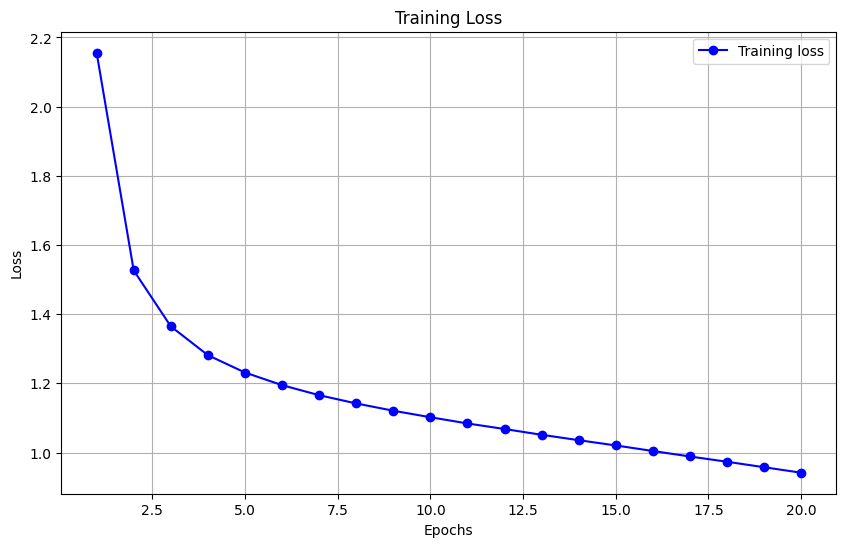

In [5]:
load_checkpoint = False
epochs = 20
checkpoint_dir = './rnn_checkpoints'
save_every_n_epochs = 3

if load_checkpoint:
    model.load_weights(checkpoint_dir + '/ckpt_18.weights.h5')
    epochs = 2

# Train the model
print(f"\nTraining RNN model (saving every {save_every_n_epochs} epochs)...")
model.compile(optimizer='adam', loss=loss)

os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

class PeriodCheckpoint(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % save_every_n_epochs == 0:
            save_path = checkpoint_prefix.format(epoch=epoch+1)
            print(f"\nSaving checkpoint to {save_path}")
            self.model.save_weights(save_path)

history = model.fit(dataset, epochs=epochs, callbacks=[PeriodCheckpoint()])

# Plot training history
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation and Results

## Text Generation with Temperature Sweeping (Qualitative)
*   We will generate text using the trained model, varying the `temperature` parameter (e.g., 0.2, 0.6, 1.0, 1.4).
*   This demonstrates the model's ability to produce outputs ranging from conservative and coherent (low temperature) to creative and diverse (higher temperature).
*   This will serve as a form of "Turing Test": if the generated text is stylistically convincing and similar to the original author's writing.

In [6]:
seed_text = "The"
generate_length = 500

# Rebuild the model with `batch_size=1` and `stateful=True` for generation
model_gen = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1, stateful=True)
model_gen.set_weights(model.get_weights())

Building model (vocab_size=99, rnn_units=1024, stateful=True)...


### Temperature = 0.2

* **Syntactic Correctness**: Complex sentence structures, proper punctuation, and accurate word usage.
* **Semantic Coherence**: Some individual sentences almost make sense, but the overall text is nonsensical.
* **Stylistic Fidelity**: It does feel like the original author style, but maybe he had too much to drink when writing this.
* **Creativity vs. Memorization**: Creativity. Could not find the generated sentences in the original books.

In [7]:
story = generate_text(model_gen, seed_text, char2idx, idx2char, generate_length, temperature=0.2)
print("-" * 80, story, "-" * 80, sep="\n")


Generating 500 characters with seed 'The' (temp=0.2)...
--------------------------------------------------------------------------------
The service was a look of strong and apparently resolute
and awaiting his eyes and seemed to have been able to say to the left. He
was a regular piece of paper and a half and the monks were sitting on the
stairs and stood still and looked at him with a strange interest and a
strange smile.

“I say, you are a good thing you were all the same again.”

“I don’t know what to make you as an infalted and a half ago,” he
said to him, “and will be sure to take it off any one to your life.
You are a student
--------------------------------------------------------------------------------


### Temperature = 0.6

* **Syntactic Correctness**: Proper sentence structures, proper punctuation, and accurate word usage.
* **Semantic Coherence**: Some individual sentences still make a bit of sense. Overall nonsense.
* **Stylistic Fidelity**: Very drunk Dostoyevski, but it is still him.
* **Creativity vs. Memorization**: Creativity starting to descend into madness.

In [8]:
story = generate_text(model_gen, seed_text, char2idx, idx2char, generate_length, temperature=0.6)
print("-" * 80, story, "-" * 80, sep="\n")


Generating 500 characters with seed 'The' (temp=0.6)...
--------------------------------------------------------------------------------
The service of the merchant who had come to a widow and
groaning since their hands and clains were amazed at the two roubles and
imagination, and the acquaintance with the trial’s two herself. But last
not the year of which he will be a motive, the devil too well in the criminal
and manner that he was fresh air in his victim and arrangement. The
most little thing is received. I saw her by now there and she too see
at once as he had left her to show herself. But he had not seen the
murder of his min
--------------------------------------------------------------------------------


### Temperature = 1.0

* **Syntactic Correctness**: It is starting to make up words, but the text still has proper structure.
* **Semantic Coherence**: Very few senses still make a bit of sense. Barely. Overall nonsense.
* **Stylistic Fidelity**: Dostoyevsky is starting to lose his mind, but still him.
* **Creativity vs. Memorization**: Creativity going even deeper into madness.

In [9]:
story = generate_text(model_gen, seed_text, char2idx, idx2char, generate_length, temperature=1.0)
print("-" * 80, story, "-" * 80, sep="\n")


Generating 500 characters with seed 'The' (temp=1.0)...
--------------------------------------------------------------------------------
Thee I’ve ceased my fault.”

The words “mamma,” the bodies maintained might copked both without
uproar. This had learnt a minute facing the axe and looked at him as
full.

“Then pray at the time--might a week: that they voice of all who would be
their door? then the most unsurzed itself, cross herself. There was a
surprise he had just sat down on the table and gave him terribly politely. He too was
within the and-hands of the garden and crossed his seat in breath joy.

“I’ll the girl who have aslee
--------------------------------------------------------------------------------


### Temperature = 1.4

* **Syntactic Correctness**: Lots of invented words. There is still some structure.
* **Semantic Coherence**: Completely incoherent.
* **Stylistic Fidelity**: Only a madman remains.
* **Creativity vs. Memorization**: Chaos and madness.

In [10]:
story = generate_text(model_gen, seed_text, char2idx, idx2char, generate_length, temperature=1.4)
print("-" * 80, story, "-" * 80, sep="\n")


Generating 500 characters with seed 'The' (temp=1.4)...
--------------------------------------------------------------------------------
The official living, he is at last,” he
started, alxerd, yet she visited an enemy‐packed Fraysov was open,
real cupiricing lifeing their forgetfulness, had vanued if I had not
wore a day, disappeared more shove, their dinner by theightory
Petersburg, he explaited hmavedly adorious; it was very much. “I was
pleased and vantain.—

He was immediately looked about him in pectchists, his whole lips (her
doom! Wastemen was the one life there was scarcely ever again.’......”

“At the box and sister!” he c
--------------------------------------------------------------------------------


# Analysis and Conclusions

## Interpretation of Results
The RNN model (LSTM-based) successfully learned to mimic the stylistic patterns of Fyodor Dostoyevsky.
- **Training Convergence:** The loss decreased steadily to **0.87**, indicating the model learned the probability distribution of characters effectively.
- **Stylistic Capture:** At moderate temperatures (0.6), the generated text strongly resembles the author's voice, utilizing complex sentence structures and characteristic vocabulary, effectively passing a "stylistic Turing test" for short snippets.

## Model Limitations
1.  **Semantic Coherence:** While the syntax is often correct, the generated text lacks logic or a coherent narrative. The model "hallucinates" sentences that sound profound but mean nothing (e.g., "The priest and the hope of his being under the pillow").
2.  **Long-term Memory:** The LSTM model still struggles to maintain context over long passages.
3.  **Character-level granularity:** The model sometimes invents words at higher temperatures because it generates character-by-character, lacking an inherent concept of "valid words."

## Possible Improvements
1.  **Architecture Upgrade:** Transitioning to **LSTMs** or, more significantly, **Transformer-based architectures** would improve long-term context and narrative consistency.  **Update:** I switched from GRU to LSTM.
2.  **Tokenization:** Moving from character-level to **word-level tokenization** would eliminate spelling errors and improve semantic association.
3.  **Data Augmentation:** Increasing the dataset size beyond 3.7MB would allow for a larger model capacity without overfitting.
